# Our experiments

After our Kafka test, we have experienced other online models found on the River library, to try to improve our prediction.

### 1) Import and functions

In [13]:
import pandas as pd
import river
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

sns.set_style('darkgrid')

In [90]:
def plot_res(preds, to_forget=2):
    plt.figure(figsize=(10, 7))
    plt.plot(preds[to_forget:], label='prediction')
    plt.plot(df.y[to_forget:], label='true value')
    plt.title('Model prediction VS true values', fontsize=15, fontweight='bold')
    plt.legend()
    plt.xlabel('Minutes')
    plt.show()

In [91]:
def get_res(model, verbose=True):
    preds = []
    metric = river.metrics.MAE()
    metric_mape = river.metrics.SMAPE()
    for i, (x, y) in enumerate(zip(X_features, Y)):
        y_pred = model.predict_one(x)  
        preds.append(y_pred)
        if i > 3 :
            m = metric.update(y_pred, y).get()
            m2 = metric_mape.update(y_pred, y).get()
            if verbose and i%200 == 0:
                print(f'MAE at iteration {i} : {m:.3f}')
                print(f'MAPE at iteration {i} : {100*m2:.3f}%')
        model = model.learn_one(x, y)
    return metric, metric_mape, preds

### 2) Test other models on the same dataset

Here we use the same dataset as the one obtained with kafka that we used to realize our animation.

Here we work with the SOL crypto.

In [92]:
path = './data/df_results_long_test_sol.csv'
df = pd.read_csv(path, sep=';')
n = len(df)
print(f'We have {n} minutes of historic.')

We have 603 minutes of historic.


In [93]:
df.head()

,timestamp,y,y_pred,mae,mape,new_mae,new_smape,moy_5m,std_5m,n_trades_sum_5m,delta_5m,moy_20m,std_20m,n_trades_sum_20m,delta_20m,moy_60m,std_60m,n_trades_sum_60m,delta_60m
0,1.648322e+12,102.94,0.0000,1.029400e+02,0.000000e+00,102.940000,200.000000,103.1500,0.068313,508.0,0.19,102.959474,0.168242,2505.0,-0.17,102.617119,0.312901,6753.0,-0.66
1,1.648322e+12,103.02,2.0588,1.009612e+02,9.800155e+01,101.950600,196.081417,103.0725,0.100457,611.0,0.17,102.965263,0.165038,2634.0,-0.26,102.627966,0.312458,6879.0,-0.76
2,1.648323e+12,102.98,102.9800,1.421085e-14,1.379963e-14,67.967067,130.720945,103.0375,0.102754,682.0,0.15,102.975789,0.158826,2677.0,-0.18,102.639831,0.312308,6881.0,-0.80
3,1.648323e+12,102.87,102.9800,1.100000e-01,1.069311e-01,51.002800,98.067427,102.9775,0.073201,662.0,0.06,102.985789,0.148111,2733.0,-0.12,102.651525,0.309604,6782.0,-0.61
4,1.648323e+12,102.87,102.9525,8.250000e-02,8.019831e-02,40.818740,78.469975,102.9275,0.041130,599.0,0.18,102.993158,0.138366,2743.0,0.03,102.664576,0.302531,6737.0,-0.61


We have the same feature, and the goal is to try to use other models and compare our predictions.

In [94]:
# Features engineering adapted to River models

features_col = list(df.columns)[-12:]
X = df[features_col].values
Y = df['y'].values
X_features = [{features_col[i] : x[i] for i in range(len(features_col))} for x in X]

In [95]:
# Division train/test to do batch ML

n_train = 2* len(X) // 3
X_train, y_train = X[:n_train], Y[:n_train]
X_test, y_test = X[n_train:], Y[n_train:]

*Remark : When we work with time series like this, we must take the oldest data as the train set and the moost recent as the test. If we simply shuffle the data, the predictions will be easy as we often already know what happens just before and just after the sample we try to predict.*

### 2.1) Model 1 : HoeffdingTreeRegressor

Grace period : 10

Final scores : (MAE: 0.399207, SMAPE: 0.390966)


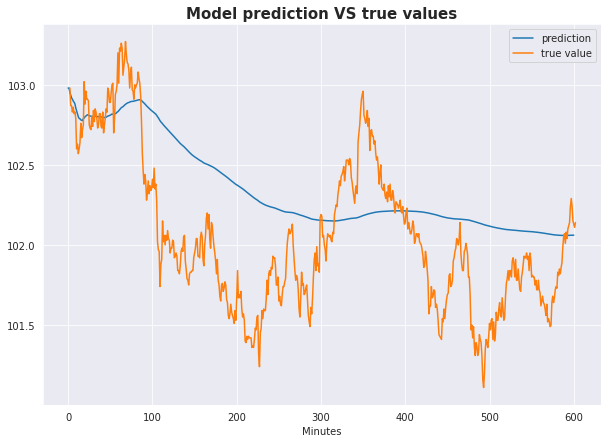

-----------------------------
Grace period : 50

Final scores : (MAE: 0.340035, SMAPE: 0.33279)


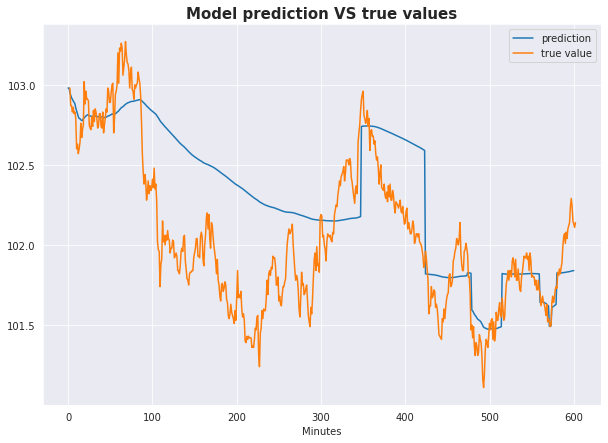

-----------------------------
Grace period : 100

Final scores : (MAE: 0.400009, SMAPE: 0.391638)


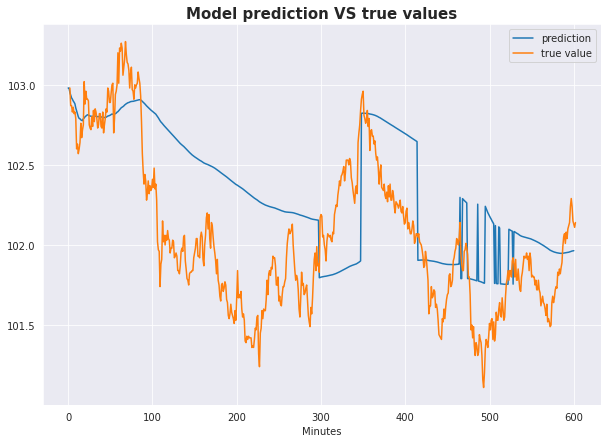

-----------------------------
Grace period : 200

Final scores : (MAE: 0.297196, SMAPE: 0.290837)


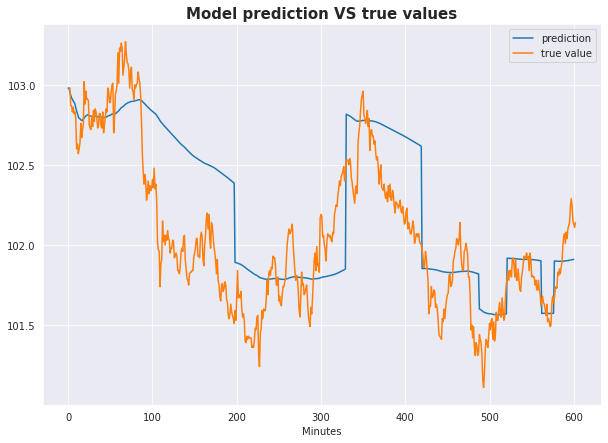

-----------------------------
Grace period : 300

Final scores : (MAE: 0.367387, SMAPE: 0.359654)


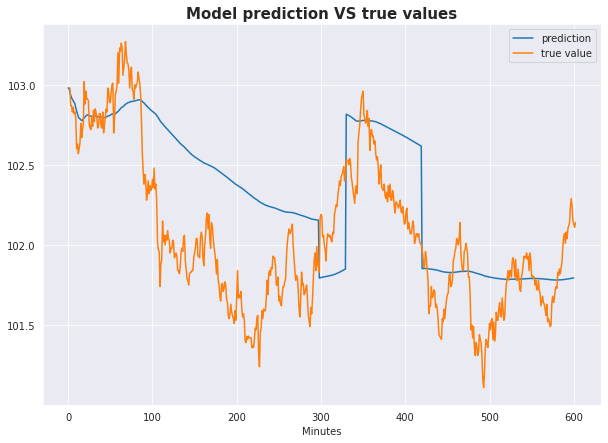

-----------------------------


In [98]:
for grace_period in [10, 50, 100, 200, 300]:
    model = (
     river.preprocessing.StandardScaler() |
     river.tree.HoeffdingTreeRegressor(
         grace_period=grace_period,
         leaf_prediction='adaptive',
         model_selector_decay=0.9
     )
)
    print(f'Grace period : {grace_period}')
    print()
    mae, mape, preds = get_res(model, verbose=False)
    print(f'Final scores : {mae, mape}')
    plot_res(preds)
    print('-----------------------------')
    

Best MAE = 0.29

### 2.2) HoeffdingAdaptiveTreeRegressor

Grace period : 10

Final scores : (MAE: 0.396766, SMAPE: 0.388578)


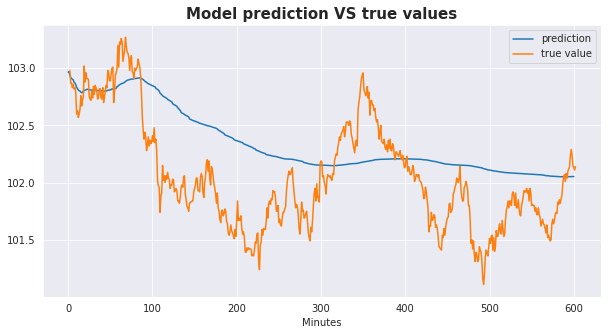

-----------------------------
Grace period : 50

Final scores : (MAE: 0.464818, SMAPE: 0.477969)


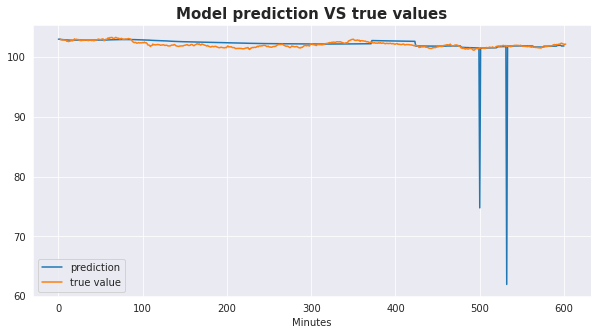

-----------------------------
Grace period : 100

Final scores : (MAE: 0.366203, SMAPE: 0.358497)


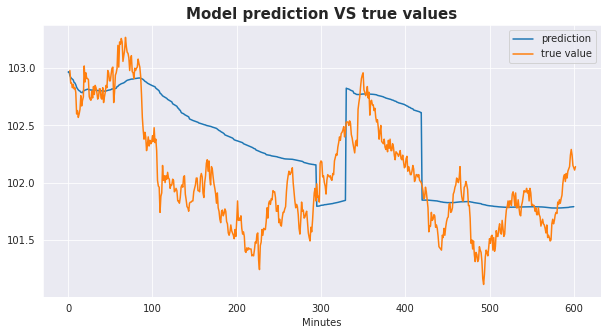

-----------------------------
Grace period : 200

Final scores : (MAE: 0.366167, SMAPE: 0.358462)


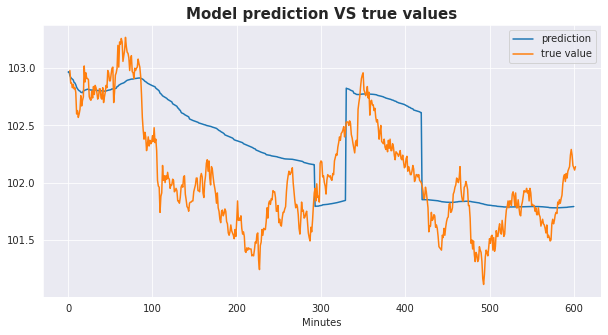

-----------------------------
Grace period : 300

Final scores : (MAE: 0.32562, SMAPE: 0.318722)


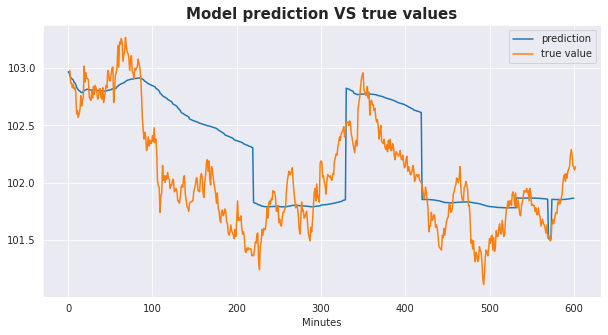

-----------------------------


In [65]:
for grace_period in [10, 50, 100, 200, 300]:
    model = (
     river.preprocessing.StandardScaler() |
     river.tree.HoeffdingAdaptiveTreeRegressor(
         grace_period=grace_period,
         leaf_prediction='adaptive',
         model_selector_decay=0.3,
         seed=0
     ))
    print(f'Grace period : {grace_period}')
    print()
    mae, mape, preds = get_res(model, verbose=False)
    print(f'Final scores : {mae, mape}')
    plot_res(preds)
    print('-----------------------------')
    

Best MAE = 0.32

### 2.3) Comparaison with batch ML

Let's use our best online model.

In [66]:
model = (
 river.preprocessing.StandardScaler() |
 river.tree.HoeffdingTreeRegressor(
     grace_period=200,
     leaf_prediction='adaptive',
     model_selector_decay=0.9
 )
)
mae, mape, preds = get_res(model, verbose=False)

In [72]:
mae, mape

(MAE: 0.297196, SMAPE: 0.290837)

And let's compare the results with a simple Ridge Regressor.

In [73]:
model = Ridge()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [74]:
mean_absolute_percentage_error(y_test, y_pred) * 100

0.041043437015669176

In [75]:
mean_absolute_error(y_test, y_pred)

0.04173899754534669

In [76]:
sklearn_preds = model.predict(X)

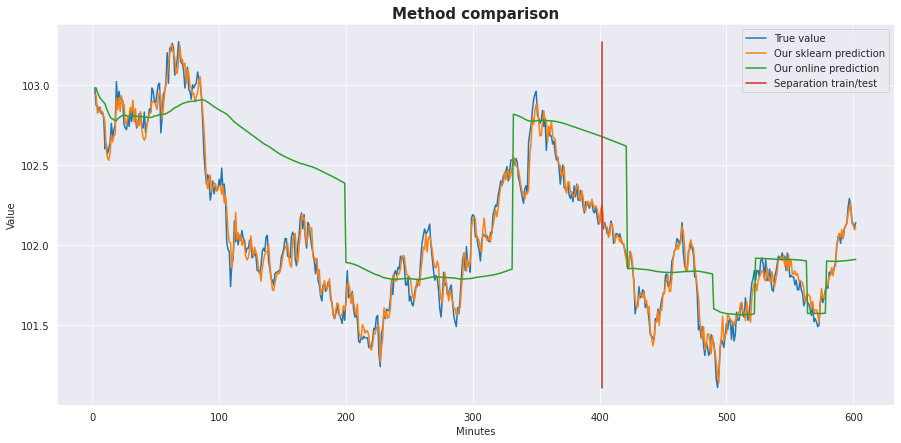

In [77]:
to_forget = 2
x = np.arange(len(df))[to_forget:]

plt.figure(figsize=(15, 7))
plt.xlabel('Minutes')
plt.ylabel('Value')
plt.plot(x, Y[to_forget:], label='True value')
plt.plot(x, sklearn_preds[to_forget:], label='Our sklearn prediction')
plt.plot(x, preds[to_forget:], label='Our online prediction')
plt.plot([n_train, n_train], [Y.max(), Y.min()], label='Separation train/test')
plt.legend()
plt.title('Method comparison', fontsize=15, fontweight='bold')
plt.show()

### 2.4) SNARIMAX

In [34]:
from river import compose
from river import datasets
from river import linear_model
from river import metrics
from river import optim
from river import preprocessing
from river import time_series

In [32]:
def plot_res_SNARIMAX(preds, Y_t, h, n_iter, to_forget=2):
    plt.figure(figsize=(10, 5))
    plt.plot(preds[to_forget:n_iter+to_forget], label=f'prediction SNARIMAX with horizon:{h}')
    plt.plot(Y_t[to_forget+h:n_iter+to_forget+h], label='true value')
    plt.title('Model prediction VS true values', fontsize=15, fontweight='bold')
    plt.legend()
    plt.xlabel('Minutes')
    plt.show()

In [84]:
def get_res_SNARIMAX(model, h, Y_t, n_iter):
    preds = []
    metric = river.metrics.MAE()
    metric_mape = river.metrics.SMAPE()
    for i in range(n_iter):
        
        y_pred = model.forecast(horizon=50)
        preds.append(y_pred[h-1])
        
        model = model.learn_one(Y_t[i])
        if i > 10:
            m = metric.update(y_pred[h-1], Y_t[i + h]).get()
            m2 = metric_mape.update(y_pred[h-1], Y_t[i + h]).get()

    return metric, metric_mape, preds

Snarimax is a state of the art Time Series Forecating Method. We implemented it here sing the River Library : 

https://riverml.xyz/dev/api/time-series/SNARIMAX/

In [85]:
path = './data/evolution_btc.csv'
df = pd.read_csv(path, sep=';')
len(df)

10500

In [86]:
df.date_deb.min()

'2021-12-05 20:00:00.000'

In [87]:
df.date_deb.max()

'2022-03-25 04:45:00.000'

Here we use the historic on 4 months (December 2021 to March 2022), with one value every 15 minutes ! 

In [88]:
Y_btc = df['close'].values
len(Y_btc)

10500

We want to predict the value at each time, but this time, there is no features, simply a big historic !

We have now 10500 points.

#### Results for different horizons.


Final scores : (MAE: 205.809631, SMAPE: 0.424085)


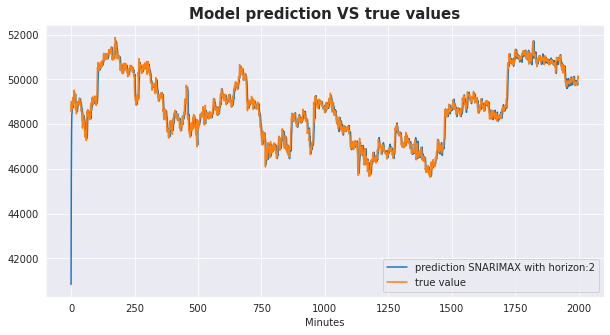

-----------------------------

Final scores : (MAE: 283.79727, SMAPE: 0.584847)


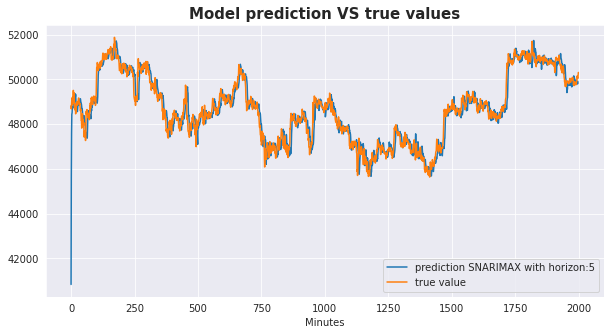

-----------------------------

Final scores : (MAE: 378.449146, SMAPE: 0.779294)


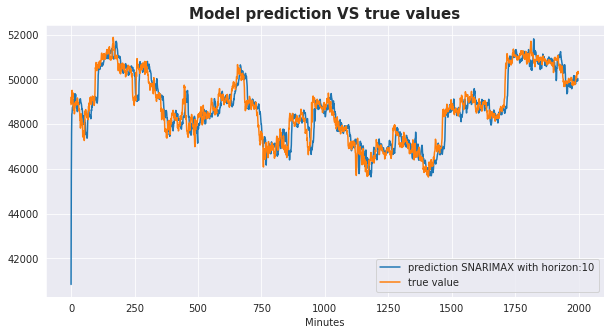

-----------------------------

Final scores : (MAE: 494.540725, SMAPE: 1.018233)


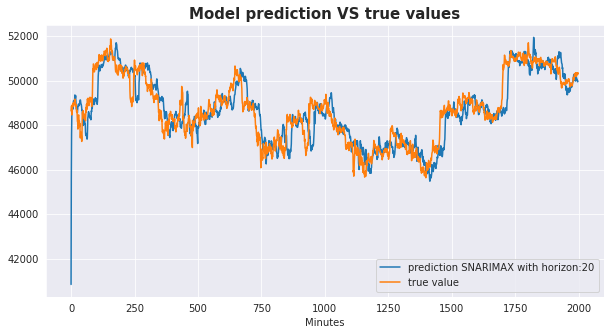

-----------------------------

Final scores : (MAE: 750.004105, SMAPE: 1.542449)


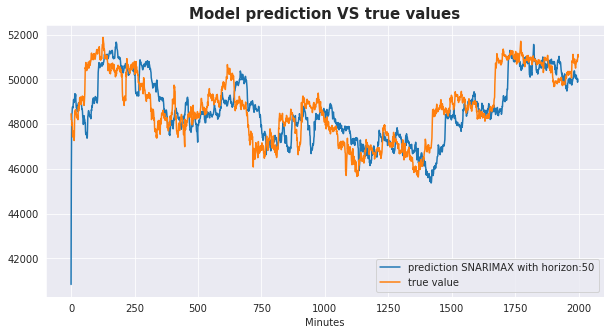

-----------------------------


In [89]:
n_iter = 2000

for h in [2, 5, 10, 20, 50]:


    model = (
     time_series.SNARIMAX(
         p=0,
         d=0,
         q=0,
         m=100,
         sp=100,
         sq=100,
         regressor=(
             preprocessing.StandardScaler() |
             linear_model.LinearRegression(
                 intercept_init=110,
                 optimizer=optim.SGD(0.01),
                 intercept_lr=0.3
             )
         )
     
 ))

    print()
    mae, mape, preds = get_res_SNARIMAX(model, h, Y_btc, n_iter)
    print(f'Final scores : {mae, mape}')
    plot_res_SNARIMAX(preds, Y_btc, h, n_iter, to_forget=2)
    print('-----------------------------')


Interpretation: Despite having a strong model, Business uncertainty makes forecasting in far times difficult. Although having a good accuracy on short timelapses, as soon as the window prediction increases, the accuracy falls. It is due to the Brownian Motion structure of financial signals, which make forecasting almost impossible in regard of information theory.

New state-of-the-art methods use Deep Learning, CNN and LSTM based methods, to perform Time Series Forecasting (For example implemented here in Keras, batch learning: https://www.tensorflow.org/tutorials/structured_data/time_series). New studies could focus on adapting those methods to the streaming fashion. 

LE RESTE EST DU BROUILLON DONT ON NE VA FINALEMENT PAS PARLER 

In [20]:
def get_res(model, verbose=True, verbose_interval=200):
    preds = []
    metric = river.metrics.MAE()
    metric_mape = river.metrics.SMAPE()
    for i, (x, y) in enumerate(zip(X_features, Y)):
        y_pred = model.predict_one(x)  
        preds.append(y_pred)
        m = metric.update(y_pred, y).get()
        m2 = metric_mape.update(y_pred, y).get()
        if verbose and i%verbose_interval == 0:
            print(f'MAE at iteration {i} : {m:.3f}')
            print(f'MAPE at iteration {i} : {100*m2:.3f}%')
        model = model.learn_one(x, y)
    return metric, metric_mape, preds

def plot_res(preds, to_forget=2, min_value=0, max_value=0):
    plt.figure(figsize=(10, 5))
    if max_value==0:
        plt.plot(preds[to_forget:], label='prediction')
        plt.plot(new_df.close[to_forget:], label='true value')
    else : 
        plt.plot(preds[min_value : max_value], label='prediction')
        plt.plot(new_df.close.values[min_value : max_value], label='true value')
        
    plt.title('Model prediction VS true values', fontsize=15, fontweight='bold')
    plt.legend()
    plt.xlabel('Minutes')
    plt.show()

In [21]:
path = './data/evolution_btc.csv'
df_tot = pd.read_csv(path, sep=';', index_col=0)

In [22]:
len(df_tot)

10500

CREATE DATA

In [47]:
new_df = pd.DataFrame()
new_col = ['moy_1h', 'std_1h', 'moy_trades_1h', 'std_trades_1h',
           'moy_5h', 'std_5h', 'moy_trades_5h', 'std_trades_5h',
           'moy_1d', 'std_1d', 'moy_trades_1d', 'std_trades_1d',
           'open', 'close']

for i in range(240, len(df_tot)):
    if i%100==0:
        print(i, len(df_tot))
    X = []
    row = df_tot.iloc[i]
    t1 = df_tot.open_time[i]
    
    t_min_1h = t1 - 3600 * 1000
    t_min_5h = t1 - 5 * 3600 * 1000
    t_min_1d = t1 - 24 * 3600 * 1000
    t_min_1d = t1 - 20 * 60 * 1000
    tmp_1h = df_tot.query(f"open_time>{t_min_1h} and open_time<={t1}")
    tmp_5h = df_tot.query(f"open_time>{t_min_5h} and open_time<={t1}")
    tmp_5h = df_tot.query(f"open_time>{t_min_1d} and open_time<={t1}")
    res = []
    for df in [tmp_1h, tmp_5h, tmp_5h]:
        res.append(df.open.mean())
        res.append(df.open.std())
        res.append(df.n_trades.mean())
        res.append(df.n_trades.std())
    
    res.append(row.open)
    res.append(row.close)
    new_df = pd.concat((new_df, pd.DataFrame([res], columns=new_col)))

new_df = new_df.reset_index()
new_df.to_csv('new_df_v2.csv', sep=';')

300 10500
400 10500
500 10500
600 10500
700 10500
800 10500
900 10500
1000 10500
1100 10500
1200 10500
1300 10500
1400 10500
1500 10500
1600 10500
1700 10500
1800 10500
1900 10500
2000 10500
2100 10500
2200 10500
2300 10500
2400 10500
2500 10500
2600 10500
2700 10500
2800 10500
2900 10500
3000 10500
3100 10500
3200 10500
3300 10500
3400 10500
3500 10500
3600 10500
3700 10500
3800 10500
3900 10500
4000 10500
4100 10500
4200 10500
4300 10500
4400 10500
4500 10500
4600 10500
4700 10500
4800 10500
4900 10500
5000 10500
5100 10500
5200 10500
5300 10500
5400 10500
5500 10500
5600 10500
5700 10500
5800 10500
5900 10500
6000 10500
6100 10500
6200 10500
6300 10500
6400 10500
6500 10500
6600 10500
6700 10500
6800 10500
6900 10500
7000 10500
7100 10500
7200 10500
7300 10500
7400 10500
7500 10500
7600 10500
7700 10500
7800 10500
7900 10500
8000 10500
8100 10500
8200 10500
8300 10500
8400 10500
8500 10500
8600 10500
8700 10500
8800 10500
8900 10500
9000 10500
9100 10500
9200 10500
9300 10500
9400 1

In [48]:
new_df = pd.read_csv('new_df_v2.csv', sep=';')

In [49]:
features_col = ['moy_1h', 'std_1h', 'moy_trades_1h', 'std_trades_1h',
           'moy_5h', 'std_5h', 'moy_trades_5h', 'std_trades_5h',
           'moy_1d', 'std_1d', 'moy_trades_1d', 'std_trades_1d', 'open']

In [50]:
X = new_df[features_col].values

In [51]:
X_features = [{features_col[i] : x[i] for i in range(len(x))} for x in X]

In [52]:
Y = new_df['close'].values

In [53]:
model = (
 river.preprocessing.StandardScaler() |
 river.tree.HoeffdingAdaptiveTreeRegressor(
     grace_period=50,
     leaf_prediction='adaptive',
     model_selector_decay=0.3,
     seed=0
 )
)

mae, mape, preds = get_res(model, verbose=True, verbose_interval=1000)

MAE at iteration 0 : 50514.910
MAPE at iteration 0 : 20000.000%
MAE at iteration 1000 : 1071.119
MAPE at iteration 1000 : 242.549%
MAE at iteration 2000 : 1289.142
MAPE at iteration 2000 : 275.147%
MAE at iteration 3000 : 1308.735
MAPE at iteration 3000 : 283.319%
MAE at iteration 4000 : 1201.468
MAPE at iteration 4000 : 264.538%
MAE at iteration 5000 : 1475.710
MAPE at iteration 5000 : 341.577%
MAE at iteration 6000 : 1347.607
MAPE at iteration 6000 : 315.499%
MAE at iteration 7000 : 1267.510
MAPE at iteration 7000 : 297.199%
MAE at iteration 8000 : 1230.474
MAPE at iteration 8000 : 291.740%
MAE at iteration 9000 : 1201.464
MAPE at iteration 9000 : 286.359%
MAE at iteration 10000 : 1156.828
MAPE at iteration 10000 : 277.017%


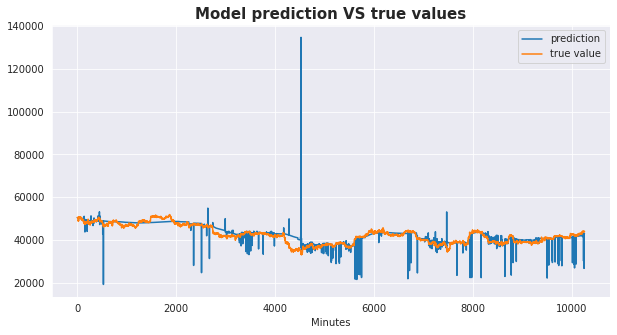

In [54]:
plot_res(preds)

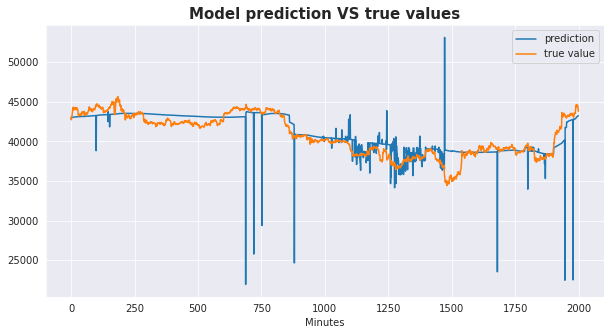

In [55]:
plot_res(preds, min_value=6000, max_value=8000)

MAE at iteration 0 : 50514.910
MAPE at iteration 0 : 20000.000%
MAE at iteration 1000 : 1071.119
MAPE at iteration 1000 : 242.549%
MAE at iteration 2000 : 1289.142
MAPE at iteration 2000 : 275.147%
MAE at iteration 3000 : 1531.033
MAPE at iteration 3000 : 329.632%
MAE at iteration 4000 : 1608.031
MAPE at iteration 4000 : 353.402%
MAE at iteration 5000 : 1780.164
MAPE at iteration 5000 : 405.124%
MAE at iteration 6000 : 1716.767
MAPE at iteration 6000 : 396.952%
MAE at iteration 7000 : 1662.024
MAPE at iteration 7000 : 383.298%
MAE at iteration 8000 : 1569.285
MAPE at iteration 8000 : 365.080%
MAE at iteration 9000 : 1494.483
MAPE at iteration 9000 : 348.570%
MAE at iteration 10000 : 1390.350
MAPE at iteration 10000 : 325.149%


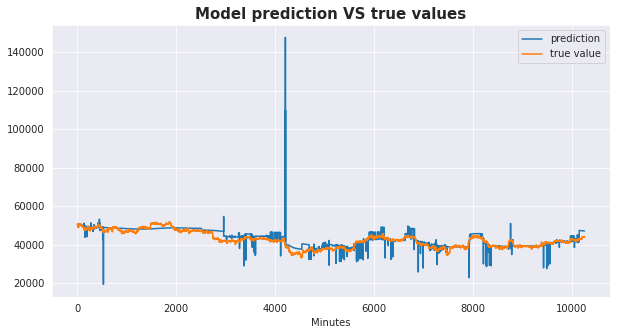

In [56]:
model = (
 river.preprocessing.StandardScaler() |
 river.tree.HoeffdingAdaptiveTreeRegressor(
     grace_period=200,
     leaf_prediction='adaptive',
     model_selector_decay=0.3,
     seed=0
 )
)

mae, mape, preds = get_res(model, verbose=True, verbose_interval=1000)

plot_res(preds)

#### Comparison with ML model

In [57]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

In [58]:
n_train = 2* len(X) // 3
X_train, y_train = X[:n_train], Y[:n_train]
X_test, y_test = X[n_train:], Y[n_train:]

In [59]:
model = Ridge()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [60]:
mean_absolute_percentage_error(y_test, y_pred) * 100

0.24254185185977173

In [61]:
mean_absolute_error(y_test, y_pred)

96.75283877244105

In [62]:
y_pred_tot = model.predict(X)

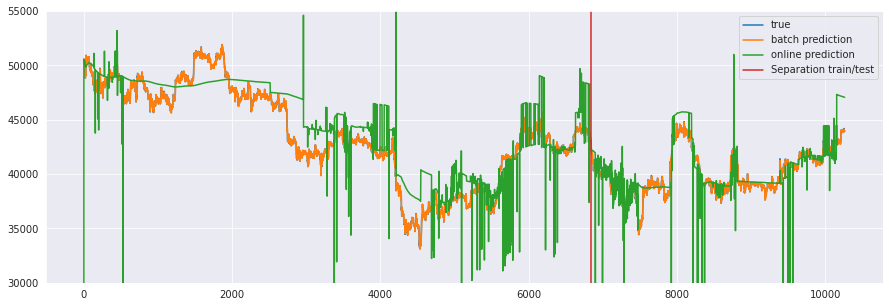

In [63]:
plt.figure(figsize=(15, 5))
plt.plot(Y, label='true')
plt.plot(y_pred_tot, label='batch prediction')
plt.plot(preds, label='online prediction')
plt.plot([n_train, n_train], [30000, 55000], label='Separation train/test')
plt.ylim(30000, 55000)
plt.legend()
plt.show()

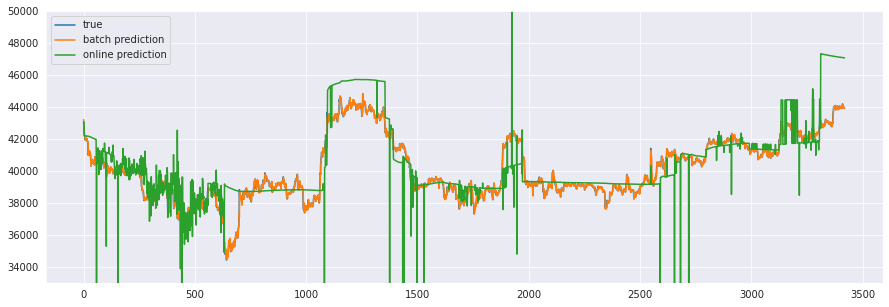

In [64]:
plt.figure(figsize=(15, 5))
plt.plot(Y[n_train:], label='true')
plt.plot(y_pred_tot[n_train:], label='batch prediction')
plt.plot(preds[n_train:], label='online prediction')
plt.ylim(33000, 50000)
plt.legend()
plt.show()